In [1]:
import sys
sys.path.append('../')
import os
os.chdir('../')
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
import os 
import torch
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from os.path import join as pjoin
from torch.distributions import Categorical
import json
import clip

import options.option_transformer as option_trans
import models.vqvae as vqvae
import utils.utils_model as utils_model
import utils.eval_trans as eval_trans
from dataset import dataset_TM_train
from dataset import dataset_TM_eval
from dataset import dataset_tokenize
import models.t2m_trans as trans
from options.get_eval_option import get_opt
from models.evaluator_wrapper import EvaluatorModelWrapper
import warnings
warnings.filterwarnings('ignore')
from exit.utils import get_model, visualize_2motions, generate_src_mask, uniform, cosine_schedule
from einops import rearrange, repeat
import os
import torch.nn.functional as F
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

/home/epinyoan/miniconda3/envs/T2M-GPT/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Temp:
    def __init__(self):
        print('mock:: opt')
args = Temp()
args.dataname = args.dataset_name = 't2m'
args.down_t = 2

train_loader_token = dataset_tokenize.DATALoader(args.dataname, 1, unit_length=2**args.down_t)

from utils.word_vectorizer import WordVectorizer
w_vectorizer = WordVectorizer('./glove', 'our_vab')
val_loader = dataset_TM_eval.DATALoader(args.dataname, False, 32, w_vectorizer)

dataset_opt_path = 'checkpoints/kit/Comp_v6_KLD005/opt.txt' if args.dataname == 'kit' else 'checkpoints/t2m/Comp_v6_KLD005/opt.txt'

wrapper_opt = get_opt(dataset_opt_path, torch.device('cuda'))
eval_wrapper = EvaluatorModelWrapper(wrapper_opt)

mock:: opt


100%|██████████| 1460/1460 [00:00<00:00, 2852.75it/s]


Pointer Pointing at 0
Reading checkpoints/t2m/Comp_v6_KLD005/opt.txt
Loading Evaluation Model Wrapper (Epoch 28) Completed!!


In [4]:
##### ---- Network ---- #####
clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda'), jit=False)  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

# https://github.com/openai/CLIP/issues/111
class TextCLIP(torch.nn.Module):
    def __init__(self, model) :
        super(TextCLIP, self).__init__()
        self.model = model
        
    def forward(self,text):
        return self.model.encode_text(text)
clip_model = TextCLIP(clip_model)

In [11]:
args.nb_code = 512 # 8192 # 
args.code_dim = 512 # 32 # 
args.output_emb_width = 512
args.down_t = 2
args.stride_t = 2
args.width = 512
args.depth = 3
args.dilation_growth_rate = 3
args.vq_act = 'relu'
args.vq_norm = None
args.quantizer = 'ema_reset'
args.mu = 0.99
args.clip_dim = 512
args.block_size = 51
args.n_head_gpt = 16
args.drop_out_rate = 0.1
args.ff_rate = 4


######## LARGE ########
args.num_layers = 9
args.embed_dim_gpt = 1024
# args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/2023-04-17-21-52-42_HML3D_18_lossAllToken_vqLast_big/net_best_fid.pth'
# args.resume_pth = f'/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/VQVAE_official_pretrain/net_best_fid.pth'
# args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/2023-04-17-21-52-42_HML3D_18_lossAllToken_vqLast_big/net_best_fid.pth'
args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/DELETE_2023-05-22-10-40-53_HML3D_31_CFG/net_last.pth'
args.resume_pth = f'/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/VQVAE_official_last/net_last.pth'

######## SMALL ########
# args.num_layers = 8
# args.embed_dim_gpt = 512
# args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/2023-04-15-19-33-09_HML3D_11_lossAllTokenAtOnce_officialVQ/net_last.pth'
# args.resume_pth = f'/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/VQVAE_official_pretrain/net_best_fid.pth'
# args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/2023-04-17-21-53-21_HML3D_17_lossAllToken_vqLast_small/net_best_fid.pth'
# args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/2023-04-17-21-53-21_HML3D_17_lossAllToken_vqLast_small/net_last.pth'
# args.resume_pth = f'/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/VQVAE_official_last/net_last.pth'

if args.dataset_name == 'kit':
    args.vq_name = 'VQVAE'
elif args.dataset_name == 't2m':
    args.vq_name = '2_VQVAE_HML3D'


args.exp_name = 'TEMP'
args.out_dir = 'output_GPT_Final'
args.out_dir = os.path.join(args.out_dir, f'{args.exp_name}')
args.vq_dir= f'output/{args.dataset_name}/{args.vq_name}'
codebook_dir = f'{args.vq_dir}/codebook/'
os.makedirs(args.out_dir, exist_ok = True)
os.makedirs(args.vq_dir, exist_ok = True)
os.makedirs(codebook_dir, exist_ok = True)

net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)
trans_encoder = trans.Text2Motion_Transformer(num_vq=args.nb_code, 
                                    embed_dim=args.embed_dim_gpt, 
                                    clip_dim=args.clip_dim, 
                                    block_size=args.block_size, 
                                    num_layers=args.num_layers, 
                                    n_head=args.n_head_gpt, 
                                    drop_out_rate=args.drop_out_rate, 
                                    fc_rate=args.ff_rate)

ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
# net = torch.nn.DataParallel(net)

ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder = torch.nn.DataParallel(trans_encoder)
net.eval()
net.cuda()
trans_encoder.train()
trans_encoder.cuda()
''

''

### Train

In [12]:
args.batch_size = 2
num_workers = 8
train_loader = dataset_TM_train.DATALoader(args.dataname, args.batch_size, args.nb_code, codebook_dir, unit_length=2**args.down_t, num_workers=num_workers)
train_loader_iter = dataset_TM_train.cycle(train_loader)

100%|██████████| 23384/23384 [00:04<00:00, 4708.63it/s]


In [13]:
args.pkeep = .5
batch = next(train_loader_iter)
clip_text, target, m_tokens_len = batch
batch_size, max_len = target.shape[:2]
target, m_tokens_len = target.cuda(), m_tokens_len.cuda()
bs = target.shape[0]

text = clip.tokenize(clip_text, truncate=True).cuda()

feat_clip_text = clip_model(text).float()

# [INFO] Swap input index
if args.pkeep == -1:
    proba = np.random.rand(1)[0]
    mask = torch.bernoulli(proba * torch.ones(target.shape,
                                                        device=target.device))
else:
    mask = torch.bernoulli(args.pkeep * torch.ones(target.shape,
                                                        device=target.device))
# random only motion token (not pad token). To prevent pad token got mixed up.
seq_mask_no_end = generate_src_mask(max_len, m_tokens_len)
mask = torch.logical_or(mask, ~seq_mask_no_end).int()
r_indices = torch.randint_like(target, args.nb_code)
input_indices = mask*target+(1-mask)*r_indices

In [14]:
#### Mock forward to see attn mask
masked_input_indices = torch.tensor([[123, 514, 377, 514, 513, 513, 513],
                                    [514, 234, 514, 377, 514, 513, 513]]).cuda()
seq_mask = generate_src_mask(7, torch.tensor([4, 5]))
att_txt = torch.rand((seq_mask.shape[0], 1)) > 0.1
_ = trans_encoder(masked_input_indices, feat_clip_text, seq_mask, att_txt)[:, 1:]

In [9]:
# Time step masking
mask_id = get_model(net).vqvae.num_code + 2
rand_time = uniform((batch_size,), device = target.device)
rand_mask_probs = cosine_schedule(rand_time)
num_token_masked = (m_tokens_len * rand_mask_probs).round().clamp(min = 1)

# batch_randperm = torch.rand((batch_size, max_len), device = target.device).argsort(dim = -1)
seq_mask = generate_src_mask(max_len, m_tokens_len+1)
batch_randperm = torch.rand((batch_size, max_len), device = target.device) - seq_mask.int()
batch_randperm = batch_randperm.argsort(dim = -1)
mask_token = batch_randperm < rearrange(num_token_masked, 'b -> b 1')

masked_target = torch.where(mask_token, input=target, other=-1)
masked_input_indices = torch.where(mask_token, mask_id, input_indices)

att_txt = torch.rand((seq_mask.shape[0], 1)) > 0.1
cls_pred = trans_encoder(masked_input_indices, feat_clip_text, seq_mask, att_txt)[:, 1:]
cls_pred = cls_pred.contiguous()

# check that the random applies only actual seq not the blank
torch.equal((mask_token * seq_mask).sum(-1), mask_token.sum(-1))

True

In [10]:
### TEST transformer
feat_clip_text = torch.rand([2, 512]).cuda()
masked_input_indices = torch.ones([2, 50]).int().cuda()
index_motion = trans_encoder(masked_input_indices, feat_clip_text, src_mask=seq_mask)

In [10]:
# 4. xent and apply weight later
loss_cls4 = F.cross_entropy(rearrange(cls_pred, 'b n c -> b c n'), masked_target, reduction = 'none')
weights = mask_token / (mask_token.sum(-1).unsqueeze(-1) * mask_token.shape[0])
loss_cls4 = (loss_cls4*weights).sum()
loss_cls4, weights.sum()

# 5. mask first and xent later. Since we need "cls_pred_all_masked" to calculate acc so use this version
cls_pred_all_masked = torch.masked_select(cls_pred, mask_token.unsqueeze(-1)).view(-1, cls_pred.shape[-1])
target_all_masked = torch.masked_select(target, mask_token)
weight_all_masked = torch.masked_select(weights, mask_token)
loss_cls5 = F.cross_entropy(cls_pred_all_masked, target_all_masked, reduction = 'none')
loss_cls5 = (loss_cls5 * weight_all_masked).sum()
loss_cls4, loss_cls5

(tensor(21.0409, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(21.0409, device='cuda:0', grad_fn=<SumBackward0>))

In [11]:
##### Loss all token (no pad) ###########
target_all = seq_mask * target
cls_pred_all = seq_mask[..., None] * cls_pred
# t [d1 N] => [N d1],  c [d1 N C] => [N C d1]
loss_cls_all = F.cross_entropy(rearrange(cls_pred_all, 'b n c -> b c n'), target_all)


probs_all = torch.softmax(cls_pred_all, dim=-1)
_, cls_pred_all_index = torch.max(probs_all, dim=-1)
right_num_all = (cls_pred_all_index == target_all).sum().item()
nb_sample_train_all = seq_mask.sum()
right_num_all/nb_sample_train_all

target_all.shape

torch.Size([2, 51])

In [12]:
#### No Mask Token Loss #########
no_mask_token = ~mask_token * seq_mask
weight_no_masked = no_mask_token / (no_mask_token.sum(-1).unsqueeze(-1) * no_mask_token.shape[0])

cls_pred_no_masked = torch.masked_select(cls_pred, no_mask_token.unsqueeze(-1)).view(-1, cls_pred.shape[-1])
target_no_masked = torch.masked_select(target, no_mask_token)
weight_no_masked = torch.masked_select(weight_no_masked, no_mask_token)
# weight_no_masked.sum() == 1
loss_cls_no_masked = F.cross_entropy(cls_pred_no_masked, target_no_masked, reduction = 'none')
loss_cls_no_masked = (loss_cls_no_masked * weight_no_masked).sum()

#### Acc No Mask Token #########
probs_no_masked = torch.softmax(cls_pred_no_masked, dim=-1)
_, cls_pred_no_masked_index = torch.max(probs_no_masked, dim=-1)
target_no_masked = torch.masked_select(target, no_mask_token)
right_no_masked = (cls_pred_no_masked_index == target_no_masked).sum().item()
right_no_masked*100/seq_mask.sum()
loss_cls_no_masked

weight_no_masked.sum()
# loss_cls_final = .8*loss_cls5 + .2*loss_cls_no_masked

tensor(1., device='cuda:0')

In [13]:
#### All Token No Separate Loss #########
weights = seq_mask / (seq_mask.sum(-1).unsqueeze(-1) * seq_mask.shape[0])
cls_pred_seq_masked = torch.masked_select(cls_pred, seq_mask.unsqueeze(-1)).view(-1, cls_pred.shape[-1])
target_seq_masked = torch.masked_select(target, seq_mask)
weight_seq_masked = torch.masked_select(weights, seq_mask)
loss_cls = F.cross_entropy(cls_pred_seq_masked, target_seq_masked, reduction = 'none')
loss_cls = (loss_cls * weight_seq_masked).sum()
loss_cls, weight_seq_masked.sum()

#### Acc  #########
probs_seq_masked = torch.softmax(cls_pred_seq_masked, dim=-1)
_, cls_pred_seq_masked_index = torch.max(probs_seq_masked, dim=-1)
target_seq_masked = torch.masked_select(target, seq_mask)
right_seq_masked = (cls_pred_seq_masked_index == target_seq_masked).sum()
right_seq_masked*100/seq_mask.sum()

#### For Acc Log, separate mast/no mask
def get_acc(cls_pred, target, mask):
    cls_pred = torch.masked_select(cls_pred, mask.unsqueeze(-1)).view(-1, cls_pred.shape[-1])
    target_all = torch.masked_select(target, mask)
    probs = torch.softmax(cls_pred, dim=-1)
    _, cls_pred_index = torch.max(probs, dim=-1)
    right_num = (cls_pred_index == target_all).sum()
    return right_num*100/mask.sum()
get_acc(cls_pred, target, mask_token), get_acc(cls_pred, target, no_mask_token)

(tensor(6.2500, device='cuda:0'), tensor(5.8824, device='cuda:0'))

In [14]:
######### Compute Acc. #########
args.if_maxtest = True # [INFO] for deterministic testing
probs = torch.softmax(cls_pred_all_masked, dim=-1)
if args.if_maxtest:
    _, cls_pred_index = torch.max(probs, dim=-1)
else:
    dist = Categorical(probs)
    cls_pred_index = dist.sample()
(cls_pred_index == target_all_masked).sum().item(), 
# cls_pred_index, target_all_masked

(2,)

In [15]:
###### Loss without random mask 

###### Compute Batch Xent ######
loss_ce = torch.nn.CrossEntropyLoss(reduction='none')
cb_idx_mask = generate_src_mask(target.shape[1], m_tokens_len+1)
cls_pred_all_masked = torch.masked_select(cls_pred, cb_idx_mask.unsqueeze(-1)).view(-1, cls_pred.shape[-1])
target_all_masked = torch.masked_select(target, cb_idx_mask)

denom = torch.ones(*target.shape).cuda() * bs * (m_tokens_len+1).unsqueeze(-1)
denom = torch.masked_select(denom, cb_idx_mask)

loss_cls = loss_ce(cls_pred_all_masked, target_all_masked) / denom
loss_cls = loss_cls.sum()

##### 2nd batch method compute loss first select later but maybe not faster b/c need to compute more loss
# T2M-GPT was working but BD got error: "RuntimeError: CUDA error: device-side assert triggered"
##############################################################################
# denom = torch.ones(*target.shape).cuda() * bs * (m_tokens_len+1).unsqueeze(-1)
# print(cls_pred.shape, target.shape, denom.shape, cb_idx_mask.shape)
# cls_pred.view(-1, cls_pred.shape[-1])
# loss_cls2 = loss_ce(cls_pred.view(-1, cls_pred.shape[-1]), 
#                     target.view(-1)).view(*denom.shape)/denom
# loss_cls2 = torch.masked_select(loss_cls2, cb_idx_mask).sum()


##### 3rd compute xent bf weight #####
loss_cls3 = F.cross_entropy(rearrange(cls_pred, 'b n c -> b c n'), target, reduction = 'none')
weights = generate_src_mask(target.shape[1], m_tokens_len+1)
weights = cb_idx_mask/(m_tokens_len+1).unsqueeze(-1) / cb_idx_mask.shape[0]
loss_cls3 = (loss_cls3*weights).sum()
loss_cls, loss_cls3

(tensor(21.1660, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(21.1660, device='cuda:0', grad_fn=<SumBackward0>))

### Eval

In [6]:

val_loader = dataset_TM_eval.DATALoader(args.dataname, False, 32, w_vectorizer)

100%|██████████| 1460/1460 [00:00<00:00, 3621.58it/s]

Pointer Pointing at 0


In [7]:
class LoggerWriterMock:
    def __init__(self):
        self.info
    def info(self, *args):
        print(*args)
    def add_scalar(self, *args):
        print(*args)
    def add_video(self, *args):
        print(*args)
logger = LoggerWriterMock()
logger.info('test')
writer = LoggerWriterMock()
writer.add_scalar('./Test/FID', 'fid', 'nb_iter')

test
./Test/FID fid nb_iter


In [8]:
########## Mask Motion in Eval ####################
index_motion = torch.randint(0, 513, (8, 51)).cuda()
blank_id = 512 # get_model(trans_encoder).num_vq
index_motion[1, 5] = blank_id
index_motion[1, 7] = blank_id
index_motion[4, 9] = blank_id
index_motion[0, 0] = blank_id
index_motion[-1, 1] = blank_id

# [INFO] 1. this get the last index of blank_id
# pred_length = (index_motion == blank_id).int().argmax(1).float()
# [INFO] 2. this get the first index of blank_id
pred_length = (index_motion >= blank_id).int()
pred_length = torch.topk(pred_length, k=1, dim=1).indices.squeeze().float()
pred_length[pred_length==0] = index_motion.shape[1]

index_motion.shape, pred_length 

(torch.Size([8, 51]),
 tensor([51.,  5., 51., 51.,  9., 51., 51.,  1.], device='cuda:0'))

In [9]:
########## Mock Masking ##########
# import torch
# import sys
# sys.path.append('../')
# from exit.utils import cosine_schedule
# mock
block_size = 52
batch_size = 4
timestep = torch.tensor(.5)
scores = torch.arange(block_size - 1).repeat(batch_size, 1).cuda()*10
scores[1] = torch.flip(torch.arange(block_size - 1), dims=(0,))*5
scores[1][2:10] = -1e5
mask_id = 514

rand_mask_prob = cosine_schedule(timestep)
ids = torch.arange(batch_size * (block_size - 1)).cuda()
ids = ids.view(batch_size, (block_size - 1))
num_token_masked = torch.tensor([5,4,3,4]).cuda() #(rand_mask_prob * m_tokens_len).int().clip(min=1)

sorted, index = scores.sort(descending=True)

## [INFO] Replace "mast_id" to "ids" that have highest "num_token_masked" "scores" 
index_select = generate_src_mask(index.shape[1], num_token_masked)
last_index = index.gather(-1, num_token_masked.unsqueeze(-1)-1)
temp_indx = index * index_select + (last_index*~index_select)
ids.scatter_(-1, temp_indx, mask_id)
ids

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45, 514, 514, 514, 514, 514],
        [514, 514,  53,  54,  55,  56,  57,  58,  59,  60, 514, 514,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
          79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
          93,  94,  95,  96,  97,  98,  99, 100, 101],
        [102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
         116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
         144, 145, 146, 147, 148, 149, 514, 514, 514],
        [153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
         167, 168, 169, 170, 171, 172, 173, 1

In [15]:
##### Steps Sample by each length
max_steps = 18
m_tokens_len = torch.tensor([30,40,50])
max_length = 50
for step in range(max_steps):
    # [0,1]
    sample_max_steps = torch.round(max_steps/max_length*m_tokens_len)
    timestep = torch.clip(step/(sample_max_steps-1), max=1)
    rand_mask_prob = cosine_schedule(timestep)
    num_token_masked = (rand_mask_prob * m_tokens_len).long().clip(min=1)
    print(num_token_masked)


tensor([30, 40, 50])
tensor([29, 39, 49])
tensor([28, 38, 49])
tensor([26, 37, 48])
tensor([24, 35, 46])
tensor([21, 32, 44])
tensor([17, 29, 42])
tensor([13, 26, 39])
tensor([ 9, 22, 36])
tensor([ 4, 18, 33])
tensor([ 1, 14, 30])
tensor([ 1,  9, 26])
tensor([ 1,  4, 22])
tensor([ 1,  1, 18])
tensor([ 1,  1, 13])
tensor([1, 1, 9])
tensor([1, 1, 4])
tensor([1, 1, 1])


In [16]:
## Test sort score with probability
scores = torch.tensor([[.9, .1, 0, 0, 0], 
                       [.5, .5, .5, 0, 0]])

# sorted, sorted_score_indices = scores.sort(descending=True)
# sorted_score_indices

scores.multinomial(scores.shape[-1], replacement=False)

tensor([[1, 0, 4, 3, 2],
        [1, 0, 2, 3, 4]])

In [211]:
########## Test Single Sample ##########
# word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name = next(iter(val_loader))
# seq = pose.shape[1]
# m_length = m_length.cuda()
m_length = torch.tensor([196, ]).cuda() # length: [196, 54]
feat_clip_text = torch.rand([1, 512]) # [2, 512]
feat_clip_text = feat_clip_text.cuda()
import timeit
total = 0
num_all = 0
blank_id = get_model(trans_encoder).num_vq
for i in range(1):
    start = timeit.default_timer()
    index_motion, temp = trans_encoder(feat_clip_text, type="sample", m_length=m_length, if_test=True, CFG=True)

    pred_length = (index_motion >= blank_id).int()
    pred_length = torch.topk(pred_length, k=1, dim=1).indices.squeeze().float()
    pred_pose = net(index_motion[:1, :int(pred_length.item())], type='decode')

    stop = timeit.default_timer()
    total += (stop - start)
    num_all += 1
total/num_all


0.38630265556275845

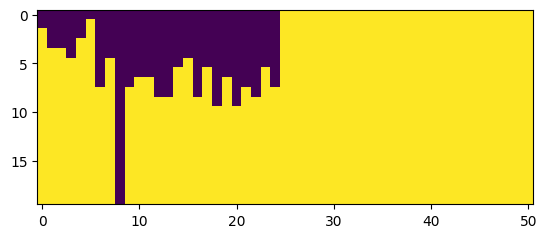

tensor([49, 25, 48, 24, 48, 23, 47, 22, 46, 20, 45, 17, 43, 14, 41, 11, 39,  7,
        37,  3, 34,  1, 31,  1, 28,  1, 25,  1, 22,  1, 18,  1, 15,  1, 11,  1,
         7,  1,  3,  1], device='cuda:0')

In [50]:
########### visualize mask in steps
mask_all_steps = torch.cat(temp, 0)*-1
gpu_skip_idx = torch.arange(mask_all_steps.shape[0]/2)*2+1
plt.imshow(mask_all_steps[gpu_skip_idx.long()].cpu().numpy())
plt.show()
mask_all_steps.sum(-1)*-1

In [ ]:
### Test Fully Conv with mask is not equal
net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)
ckpt = torch.load(args.resume_pth, map_location='cpu')
# net.load_state_dict(ckpt['net'], strict=False)
net.eval()
net.cuda()


index_motion = (torch.rand(2, 51)*512).long().cuda()
m_tokens_len = torch.tensor([10, 5]).cuda()
max_len = 51
src_mask = generate_src_mask(max_len, m_tokens_len)
index_motion = index_motion * src_mask + 512 * ~src_mask
pred_pose1 = net(index_motion, type='decode')

pred_pose2 = net(index_motion[:, :m_tokens_len[0]], type='decode')
pred_pose1[0, :50, 0], pred_pose2[0, :50, 0]

In [10]:
pred_pose_eval, pose, m_length, clip_text, best_fid, best_iter, best_div, best_top1, best_top2, best_top3, best_matching, best_multi, writer, logger = \
    eval_trans.evaluation_transformer(args.out_dir, 
        val_loader, 
        net, 
        trans_encoder, 
        logger, 
        writer, 
        0, 
        best_fid=1000, 
        best_iter=0, 
        best_div=100, 
        best_top1=0, 
        best_top2=0, 
        best_top3=0, 
        best_matching=100, 
        clip_model=clip_model, 
        eval_wrapper=eval_wrapper,
        num_repeat=11,
        rand_pos=True,
        CFG=.1)

100%|██████████| 47/47 [27:16<00:00, 34.82s/it]


--> 	 Eva. Iter 0 :, 
                FID. 0.1587 , 
                Diversity Real. 9.4543, 
                Diversity. 9.6560, 
                R_precision_real. [0.51728723 0.71609043 0.80851064], 
                R_precision. [0.48670213 0.67553191 0.76329787], 
                matching_score_real. 2.915987070570601, 
                matching_score_pred. 3.2021682972603656, 
                multimodality. 1.1540
./Test/FID 0.1587068494814048 0
./Test/Diversity 9.655975 0
./Test/top1 0.4867021276595745 0
./Test/top2 0.675531914893617 0
./Test/top3 0.7632978723404256 0
./Test/matching_score 3.2021682972603656 0
./Test/multimodality 1.1539515 0
--> --> 	 FID Improved from 1000.00000 to 0.15871 !!!
--> --> 	 matching_score Improved from 100.00000 to 3.20217 !!!
--> --> 	 Diversity Improved from 100.00000 to 9.65598 !!!
--> --> 	 Top1 Improved from 0.0000 to 0.4867 !!!
--> --> 	 Top2 Improved from 0.0000 to 0.6755 !!!
--> --> 	 Top3 Improved from 0.0000 to 0.7633 !!!


### Study Sampling Scheduler

In [3]:
##### Steps Sample by each length
max_steps = 10
m_tokens_len = torch.tensor([1, 2, 5, 10, 15, 20, 19, 25,35, 45, 49])
max_length = 49
sample_max_steps = torch.round(max_steps/max_length*m_tokens_len) + 1e-8
print(sample_max_steps)
print('------------------------------------------')
for step in range(max_steps):
    # print(step)
    # [0,1]
    timestep = torch.clip(step/(sample_max_steps), max=1)
    # print(timestep)
    rand_mask_prob = cosine_schedule(timestep)
    # print(rand_mask_prob)
    num_token_masked = (rand_mask_prob * m_tokens_len).round().clip(min=1)
    # print(num_token_masked)

    rand_mask_probs2 = cosine_schedule(timestep)
    num_token_masked2 = (m_tokens_len * rand_mask_probs2).round()
    print(num_token_masked, num_token_masked2)

tensor([1.0000e-08, 1.0000e-08, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        4.0000e+00, 5.0000e+00, 7.0000e+00, 9.0000e+00, 1.0000e+01])
------------------------------------------
tensor([ 1.,  2.,  5., 10., 15., 20., 19., 25., 35., 45., 49.]) tensor([ 1.,  2.,  5., 10., 15., 20., 19., 25., 35., 45., 49.])
tensor([ 1.,  1.,  1.,  7., 13., 18., 18., 24., 34., 44., 48.]) tensor([-0., -0., -0.,  7., 13., 18., 18., 24., 34., 44., 48.])
tensor([ 1.,  1.,  1.,  1.,  7., 14., 13., 20., 32., 42., 47.]) tensor([-0., -0., -0., -0.,  7., 14., 13., 20., 32., 42., 47.])
tensor([ 1.,  1.,  1.,  1.,  1.,  8.,  7., 15., 27., 39., 44.]) tensor([-0., -0., -0., -0., -0.,  8.,  7., 15., 27., 39., 44.])
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  8., 22., 34., 40.]) tensor([-0., -0., -0., -0., -0., -0., -0.,  8., 22., 34., 40.])
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 15., 29., 35.]) tensor([-0., -0., -0., -0., -0., -0., -0., -0., 15., 29., 35.])
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1

### Visualize Prediction

In [10]:
batch = next(iter(val_loader))
word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name = batch
k=10
text = clip.tokenize(clip_text, truncate=True).cuda()
feat_clip_text = clip_model(text).float()
index_motion = trans_encoder(feat_clip_text, type="sample", m_length=m_length.cuda())
index_motion[k]

tensor([ 30, 138, 138, 138, 220, 475,  55, 464, 464, 499, 220, 220,  90, 458,
        464,  56, 138, 503, 348, 348, 138, 138, 138, 358, 138, 358,  77, 209,
        209, 199, 138, 138, 138, 138, 314, 187, 187, 378, 425, 101, 410, 239,
        300,  14, 505, 454, 512, 513, 513, 513], device='cuda:0')

In [36]:
pred_length = (index_motion >= blank_id).int()
pred_length = torch.topk(pred_length, k=1, dim=1).indices.squeeze().float()
pred_pose = net(index_motion[k:k+1, :int(pred_length[k].item())], type='decode')

bs, seq = pose.shape[:2]
pred_pose_eval = torch.zeros((bs, seq, pose.shape[-1])).cuda()
cur_len = pred_pose.shape[1]
pred_pose_eval[k:k+1, :cur_len] = pred_pose[:, :seq]

In [37]:
x = pose[k].detach().cpu().numpy()
y = pred_pose_eval[k].detach().cpu().numpy()
l = m_length[k]
caption = clip_text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, args.dataname, l, y, save_path=None)

### Verify Left Right Issue from https://github.com/ChenFengYe/motion-latent-diffusion/issues/31 

In [62]:
clip_text = ['a person puts the left hand up.']*32
text = clip.tokenize(clip_text, truncate=True).cuda()
feat_clip_text = clip_model(text).float()
m_length = torch.ones(32).cuda()*120
index_motion = trans_encoder(feat_clip_text, type="sample", m_length=m_length.cuda(), rand_pos=True)


In [63]:
bs=32; seq=pred_pose.shape[1]
pred_pose_eval = torch.zeros((bs, seq, pred_pose.shape[-1])).cuda()
cur_len = pred_pose.shape[1]

for k in range(bs):
    pred_pose = net(index_motion[k:k+1, :30], type='decode')
    pred_pose_eval[k:k+1, :cur_len] = pred_pose[:, :seq]


In [64]:
k=3
x = pred_pose_eval[k].detach().cpu().numpy()
l = m_length[k].int()
caption = clip_text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, args.dataname, l, save_path=None)

In [65]:
k=30
x = pred_pose_eval[k].detach().cpu().numpy()
l = m_length[k].int()
caption = clip_text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, args.dataname, l, save_path=None)